# Develop New Figures Notebook

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import glob
import numpy as np
#import fitsio as fits
from astropy.io import fits

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [8, 6.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import posixpath, datetime, sys
# import cv2

In [2]:
from scipy.stats import binned_statistic_2d, binned_statistic
from skimage.measure import block_reduce
from skimage.util import view_as_blocks
from scipy.ndimage.filters import gaussian_filter
import scipy.optimize as opt

## Define new auxialiary functions

In [3]:
def compute_ellipticities(self):
    nanmask = np.isfinite(self.deltaXX) #masks all the NaN entries created when a catalog didn't have 2401 entries

    e0_total = self.xx_arr+self.yy_arr
    e1_total = (self.xx_arr-self.yy_arr)#/e0_total
    e2_total = 2*self.xy_arr#/e0_total
    en_total = np.sqrt(e1_total**2+e2_total**2)
    
    # Ixx,cal = Ixx - dIxx
    e0_cal = (self.xx_arr+self.yy_arr) - (self.dxx_arr+self.dyy_arr)
    e1_cal = (self.xx_arr-self.yy_arr) - (self.dxx_arr-self.dyy_arr)
    e2_cal = 2*self.xy_arr - 2*self.dxy_arr
    en_cal = np.sqrt(e1_cal**2+e2_cal**2)
    
    ## calibrating the measurements
    de0_all = (e0_total[self.spot_filter]-e0_cal[self.spot_filter])/e0_cal[self.spot_filter]
    de1_all = (e1_total[self.spot_filter]-e1_cal[self.spot_filter])/e0_cal[self.spot_filter]
    de2_all = (e2_total[self.spot_filter]-e2_cal[self.spot_filter])/e0_cal[self.spot_filter]
    den_all = (en_total[self.spot_filter]-en_cal[self.spot_filter])/e0_cal[self.spot_filter]

    self.e0 = de0_all[nanmask].flatten()
    self.e1 = de1_all[nanmask].flatten()
    self.e2 = de2_all[nanmask].flatten()
    self.shear = den_all[nanmask].flatten()
    
    return self

In [4]:
from collections import defaultdict
def get_imaging_map(self):
    dmap = defaultdict()
    nanmask = np.isfinite(self.deltaXX)  #masks all the NaN entries created when a catalog didn't have 2401 entries
    xxfltr_flat = self.xxfltr[nanmask].flatten()
    yyfltr_flat = self.yyfltr[nanmask].flatten()
    
    # flux-ratio
    mydict = dict().fromkeys(['abs'])
    mydict['abs'] = self.dF
    dmap['flux-ratio'] = mydict
    
    # astrometric-shift
    mydict = dict().fromkeys(['x','y','abs'])
    mydict['x'] = self.dX
    mydict['y'] = self.dY
    mydict['abs'] = np.sqrt(self.dX**2+self.dY**2)
    dmap['astrometric-shift'] = mydict
        
    # psf-size
    mydict = dict().fromkeys(['x','y','abs'])
    mydict['x'] = self.dXX/(xxfltr_flat+yyfltr_flat)
    mydict['y'] = self.dYY/(xxfltr_flat+yyfltr_flat)
    mydict['abs'] = mydict['x']+mydict['y']
    dmap['psf-size'] = mydict
    
    # ellipticity
    mydict = dict().fromkeys(['x','y','abs','abs_diff'])
    mydict['x'] = self.e1
    mydict['y'] = self.e2
    mydict['abs'] = np.sqrt(mydict['x']**2+mydict['y']**2)
    mydict['abs_diff'] = self.shear
    dmap['ellipticity'] = mydict

    self.data = dmap
    return self

## Initialize Test Dataset

In [5]:
from spotgrid_butler_yousuke import SpotgridCatalog

You are not connected to a LSST machine
Fake Bluter


In [6]:
repo25 = '/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml'
repo9 = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml'

setting = [
    (repo25, 'u/snyder18/spot_13242/gridfit_run1', 'u/snyder18/spot_13242/gridcalibration'),
    (repo25, 'u/snyder18/spot_13243/gridfit_run1', 'u/snyder18/spot_13243/gridcalibration'),
    (repo25, 'u/snyder18/spot_13237/gridfit_run1', 'u/snyder18/spot_13237/gridcalibration'),
    (repo25, 'u/snyder18/spot_13246/gridfit_run1', 'u/snyder18/spot_13246/gridcalibration'),
    (repo9, 'u/asnyder/spot/e2v_analysis', 'u/asnyder/spot/e2v_calibration'),        
    (repo9, 'u/asnyder/spot/itl_analysis', 'u/asnyder/spot/itl_calibration')]

In [24]:
idx = 5
mysetting = setting[idx]

In [25]:
print('Starting with setting')
print(',\n'.join(mysetting))

Starting with setting
/sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml,
u/asnyder/spot/itl_analysis,
u/asnyder/spot/itl_calibration


In [26]:
sensor = SpotgridCatalog(*mysetting)

#asensor.get_calibration_table()
sensor.load_data()
sensor.compute_statistics()
sensor.filter_spots(value=.4)   # value=.4
sensor.compute_spotgrid()
sensor.calibrate()

repo: /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
catalog collection: u/asnyder/spot/itl_analysis
calib collection  : u/asnyder/spot/itl_calibration


Found tmp/R02_S02_x_arr.npy
Found tmp/R02_S02_y_arr.npy
Found tmp/R02_S02_xx_arr.npy
Found tmp/R02_S02_xy_arr.npy
Found tmp/R02_S02_yy_arr.npy
Found tmp/R02_S02_dx_arr.npy
Found tmp/R02_S02_dy_arr.npy
Found tmp/R02_S02_dxx_arr.npy
Found tmp/R02_S02_dyy_arr.npy
Found tmp/R02_S02_dxy_arr.npy
Found tmp/R02_S02_instFlux_arr.npy
Found tmp/R02_S02_instFluxErr_arr.npy
Found tmp/R02_S02_x_center_arr.npy
Found tmp/R02_S02_y_center_arr.npy
Found tmp/R02_S02_dFlux_arr.npy
Found tmp/R02_S02_dg1_arr.npy
Found tmp/R02_S02_dg2_arr.npy
Loading data for ITL tmp/R02_S02.
Computing statistics for ITL tmp/R02_S02.
Computing filter spots for ITL tmp/R02_S02.


In [27]:
# new quantities
sensor = compute_ellipticities(sensor)
sensor = get_imaging_map(sensor)

# Review Filter Spot Threshold

```
self.spot_filter = (
        (self.xxyy_err < value )
        & (self.instFlux_med > 0.9*np.nanmax(self.instFlux_med) )
    )
```

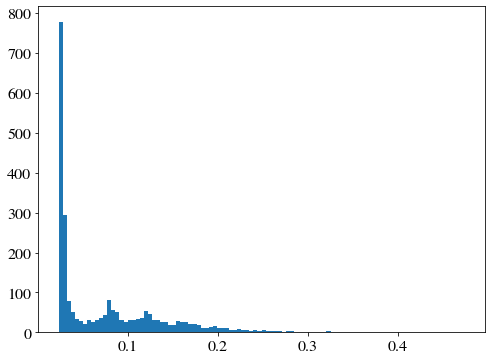

In [28]:
# xxyy_err = np.sqrt(xx_std**2+yy_std**2)
_ = plt.hist(sensor.xxyy_err,bins=100)
# _ = plt.hist(sensor.xx_std,bins=100)
# _ = plt.hist(sensor.xx_std,bins=100)


# Figure 1

In [29]:
# This cell comes from tree_ring_helper.py to override for handy
sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}

import scipy
import cv2
from astropy.stats import mad_std

def generate_image(self,datatype,component,MAX=0.07,fradius=140,bins = [407,400]): 
    '''
    Generetates a pseudo image
    datatye: 'psf-size', 'astrometric-shift', ...
    component: x, y, r, t, abs, abs_diff
    '''
    #[407, 400] approx. 10x10 px^2 binning
    dmap = self.data[datatype]
    
    dT_mean, x_edge, y_edge, binidx = binned_statistic_2d(
                                    self.xfltr_flat,
                                    self.yfltr_flat,
                                    dmap[component],
                                    lambda x: scipy.stats.norm.fit(x[np.isfinite(x)])[0],
                                    range=sensor_lims[self.sensor], bins=bins)    
    ## sensor max limits
    xmax = sensor_lims[self.sensor][0][1]
    ymax = sensor_lims[self.sensor][1][1]
    
    ## resize image
    resized     = cv2.resize(dT_mean.T,(xmax,ymax), interpolation = cv2.INTER_AREA)
    return dT_mean,resized

In [30]:
keys = {
        'astrometric-shift':['abs','Astrometric Shift [pixels]'],
        'flux-ratio':['abs','Flux-Ratio'],
        'psf-size':['abs','PSF-Size: $I_{xx}+I_{yy}$'],
        'ellipticity':['abs_diff','Shear: $\\sqrt{e_1^2+e_2^2}$']
       }


In [31]:
nsigma = 3
prop = 3/4.

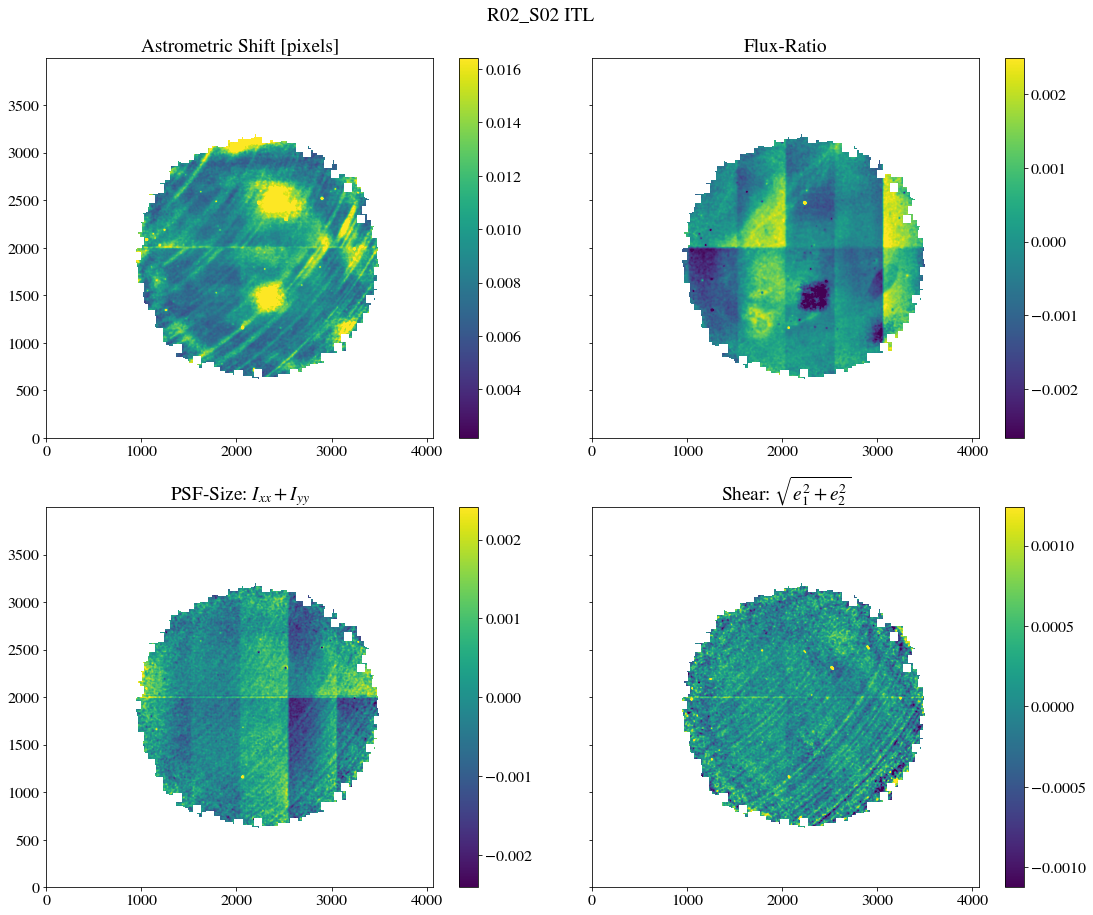

NameError: name 'self' is not defined

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16*prop + 1), sharey='all', facecolor="white")

fig.suptitle(f'{sensor.sensorbay.upper()} {sensor.sensor}')
# maps = {}
for ax, key, vals in zip(axs.flatten(), keys, keys.values()):
    #print(5*'---')
    #print(f'Variable: {key}')
    #print(f'component: {vals[0]}\n')
    
    _, img =  generate_image(sensor, key, vals[0], bins=[407,400])
    img_filtered = gaussian_filter(img,3)
    #img_filtered = apply_filter(img, 250, power=4) # power was 4
    
    std=mad_std(img_filtered, ignore_nan=True)
    m=np.nanmedian(img_filtered)
    a=ax.imshow(img_filtered,vmin=m-nsigma*std,vmax=m+nsigma*std)
    fig.colorbar(a,ax=ax)
    ax.set_title(vals[1])

fig.tight_layout()
plt.show()
fig.savefig(f'{sensor.sensorbay}_figure1.pdf',dpi=100)

In [35]:
sensors = []
for mysetting in setting:
    sensor = SpotgridCatalog(*mysetting)

    #asensor.get_calibration_table()
    sensor.load_data()
    sensor.compute_statistics()
    sensor.filter_spots(value=.4)   # value=.4
    sensor.compute_spotgrid()
    sensor.calibrate()
    # new quantities
    sensor = compute_ellipticities(sensor)
    sensor = get_imaging_map(sensor)

    sensors.append(sensor)

repo: /sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml
Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml
catalog collection: u/snyder18/spot_13242/gridfit_run1
calib collection  : u/snyder18/spot_13242/gridcalibration


Found tmp/R03_S12_x_arr.npy
Found tmp/R03_S12_y_arr.npy
Found tmp/R03_S12_xx_arr.npy
Found tmp/R03_S12_xy_arr.npy
Found tmp/R03_S12_yy_arr.npy
Found tmp/R03_S12_dx_arr.npy
Found tmp/R03_S12_dy_arr.npy
Found tmp/R03_S12_dxx_arr.npy
Found tmp/R03_S12_dyy_arr.npy
Found tmp/R03_S12_dxy_arr.npy
Found tmp/R03_S12_instFlux_arr.npy
Found tmp/R03_S12_instFluxErr_arr.npy
Found tmp/R03_S12_x_center_arr.npy
Found tmp/R03_S12_y_center_arr.npy
Found tmp/R03_S12_dFlux_arr.npy
Found tmp/R03_S12_dg1_arr.npy
Found tmp/R03_S12_dg2_arr.npy
Loading data for ITL tmp/R03_S12.
Computing statistics for ITL tmp/R03_S12.
Computing filter spots for ITL tmp/R03_S12.


repo: /sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml
Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml
catalog collection: u/snyder18/spot_13243/gridfit_run1
calib collection  : u/snyder18/spot_13243/gridcalibration


Found tmp/R10_S11_x_arr.npy
Found tmp/R10_S11_y_arr.npy
Found tmp/R10_S11_xx_arr.npy
Found tmp/R10_S11_xy_arr.npy
Found tmp/R10_S11_yy_arr.npy
Found tmp/R10_S11_dx_arr.npy
Found tmp/R10_S11_dy_arr.npy
Found tmp/R10_S11_dxx_arr.npy
Found tmp/R10_S11_dyy_arr.npy
Found tmp/R10_S11_dxy_arr.npy
Found tmp/R10_S11_instFlux_arr.npy
Found tmp/R10_S11_instFluxErr_arr.npy
Found tmp/R10_S11_x_center_arr.npy
Found tmp/R10_S11_y_center_arr.npy
Found tmp/R10_S11_dFlux_arr.npy
Found tmp/R10_S11_dg1_arr.npy
Found tmp/R10_S11_dg2_arr.npy
Loading data for ITL tmp/R10_S11.
Computing statistics for ITL tmp/R10_S11.
Computing filter spots for ITL tmp/R10_S11.


repo: /sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml
Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml
catalog collection: u/snyder18/spot_13237/gridfit_run1
calib collection  : u/snyder18/spot_13237/gridcalibration


Found tmp/R24_S11_x_arr.npy
Found tmp/R24_S11_y_arr.npy
Found tmp/R24_S11_xx_arr.npy
Found tmp/R24_S11_xy_arr.npy
Found tmp/R24_S11_yy_arr.npy
Found tmp/R24_S11_dx_arr.npy
Found tmp/R24_S11_dy_arr.npy
Found tmp/R24_S11_dxx_arr.npy
Found tmp/R24_S11_dyy_arr.npy
Found tmp/R24_S11_dxy_arr.npy
Found tmp/R24_S11_instFlux_arr.npy
Found tmp/R24_S11_instFluxErr_arr.npy
Found tmp/R24_S11_x_center_arr.npy
Found tmp/R24_S11_y_center_arr.npy
Found tmp/R24_S11_dFlux_arr.npy
Found tmp/R24_S11_dg1_arr.npy
Found tmp/R24_S11_dg2_arr.npy
Loading data for e2v tmp/R24_S11.
Computing statistics for e2v tmp/R24_S11.
Computing filter spots for e2v tmp/R24_S11.


repo: /sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml
Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml
catalog collection: u/snyder18/spot_13246/gridfit_run1
calib collection  : u/snyder18/spot_13246/gridcalibration


Found tmp/R32_S01_x_arr.npy
Found tmp/R32_S01_y_arr.npy
Found tmp/R32_S01_xx_arr.npy
Found tmp/R32_S01_xy_arr.npy
Found tmp/R32_S01_yy_arr.npy
Found tmp/R32_S01_dx_arr.npy
Found tmp/R32_S01_dy_arr.npy
Found tmp/R32_S01_dxx_arr.npy
Found tmp/R32_S01_dyy_arr.npy
Found tmp/R32_S01_dxy_arr.npy
Found tmp/R32_S01_instFlux_arr.npy
Found tmp/R32_S01_instFluxErr_arr.npy
Found tmp/R32_S01_x_center_arr.npy
Found tmp/R32_S01_y_center_arr.npy
Found tmp/R32_S01_dFlux_arr.npy
Found tmp/R32_S01_dg1_arr.npy
Found tmp/R32_S01_dg2_arr.npy
Loading data for e2v tmp/R32_S01.
Computing statistics for e2v tmp/R32_S01.
Computing filter spots for e2v tmp/R32_S01.


repo: /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
catalog collection: u/asnyder/spot/e2v_analysis
calib collection  : u/asnyder/spot/e2v_calibration


Found tmp/R22_S11_x_arr.npy
Found tmp/R22_S11_y_arr.npy
Found tmp/R22_S11_xx_arr.npy
Found tmp/R22_S11_xy_arr.npy
Found tmp/R22_S11_yy_arr.npy
Found tmp/R22_S11_dx_arr.npy
Found tmp/R22_S11_dy_arr.npy
Found tmp/R22_S11_dxx_arr.npy
Found tmp/R22_S11_dyy_arr.npy
Found tmp/R22_S11_dxy_arr.npy
Found tmp/R22_S11_instFlux_arr.npy
Found tmp/R22_S11_instFluxErr_arr.npy
Found tmp/R22_S11_x_center_arr.npy
Found tmp/R22_S11_y_center_arr.npy
Found tmp/R22_S11_dFlux_arr.npy
Found tmp/R22_S11_dg1_arr.npy
Found tmp/R22_S11_dg2_arr.npy
Loading data for e2v tmp/R22_S11.
Computing statistics for e2v tmp/R22_S11.
Computing filter spots for e2v tmp/R22_S11.


repo: /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
Repository        : /sdf/group/lsst/camera/IandT/repo_gen3/spot_9raft/butler.yaml
catalog collection: u/asnyder/spot/itl_analysis
calib collection  : u/asnyder/spot/itl_calibration


Found tmp/R02_S02_x_arr.npy
Found tmp/R02_S02_y_arr.npy
Found tmp/R02_S02_xx_arr.npy
Found tmp/R02_S02_xy_arr.npy
Found tmp/R02_S02_yy_arr.npy
Found tmp/R02_S02_dx_arr.npy
Found tmp/R02_S02_dy_arr.npy
Found tmp/R02_S02_dxx_arr.npy
Found tmp/R02_S02_dyy_arr.npy
Found tmp/R02_S02_dxy_arr.npy
Found tmp/R02_S02_instFlux_arr.npy
Found tmp/R02_S02_instFluxErr_arr.npy
Found tmp/R02_S02_x_center_arr.npy
Found tmp/R02_S02_y_center_arr.npy
Found tmp/R02_S02_dFlux_arr.npy
Found tmp/R02_S02_dg1_arr.npy
Found tmp/R02_S02_dg2_arr.npy
Loading data for ITL tmp/R02_S02.
Computing statistics for ITL tmp/R02_S02.
Computing filter spots for ITL tmp/R02_S02.


/usr/local/anaconda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:366: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:371: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


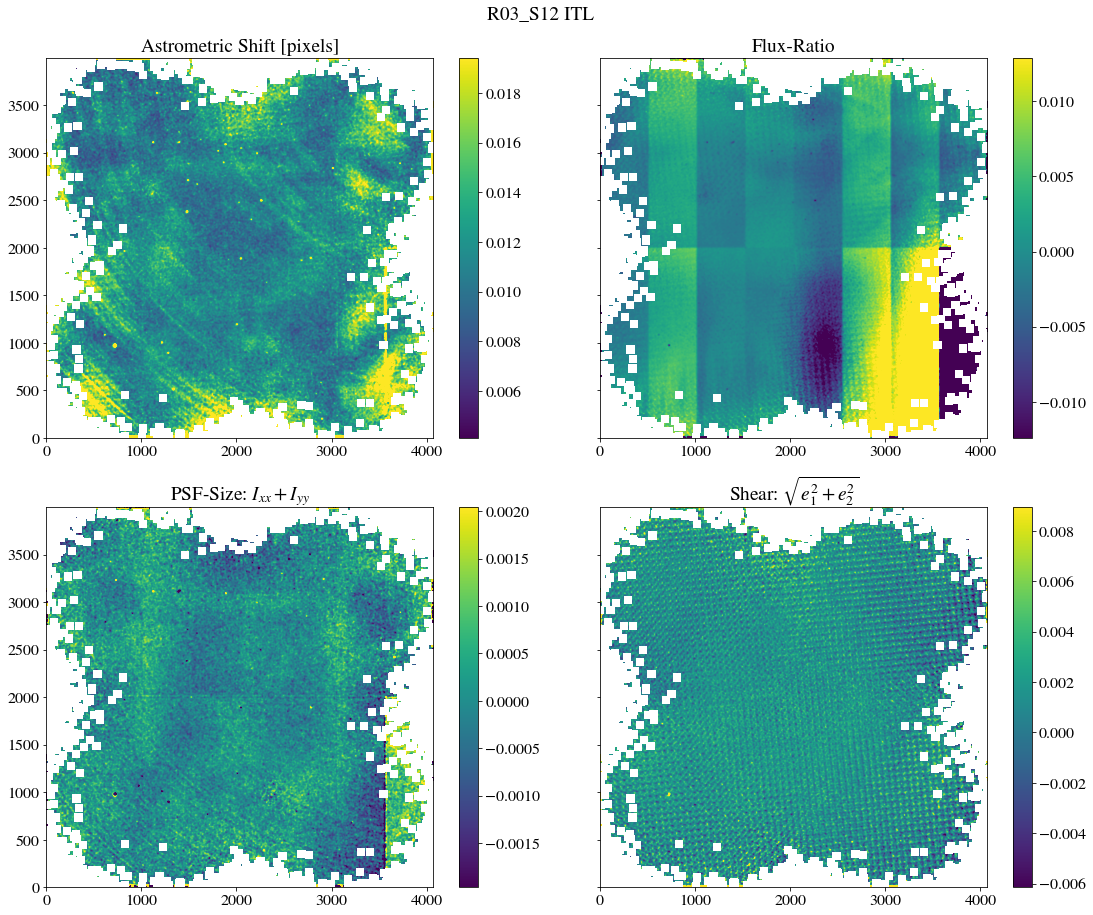

/usr/local/anaconda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:366: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:371: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


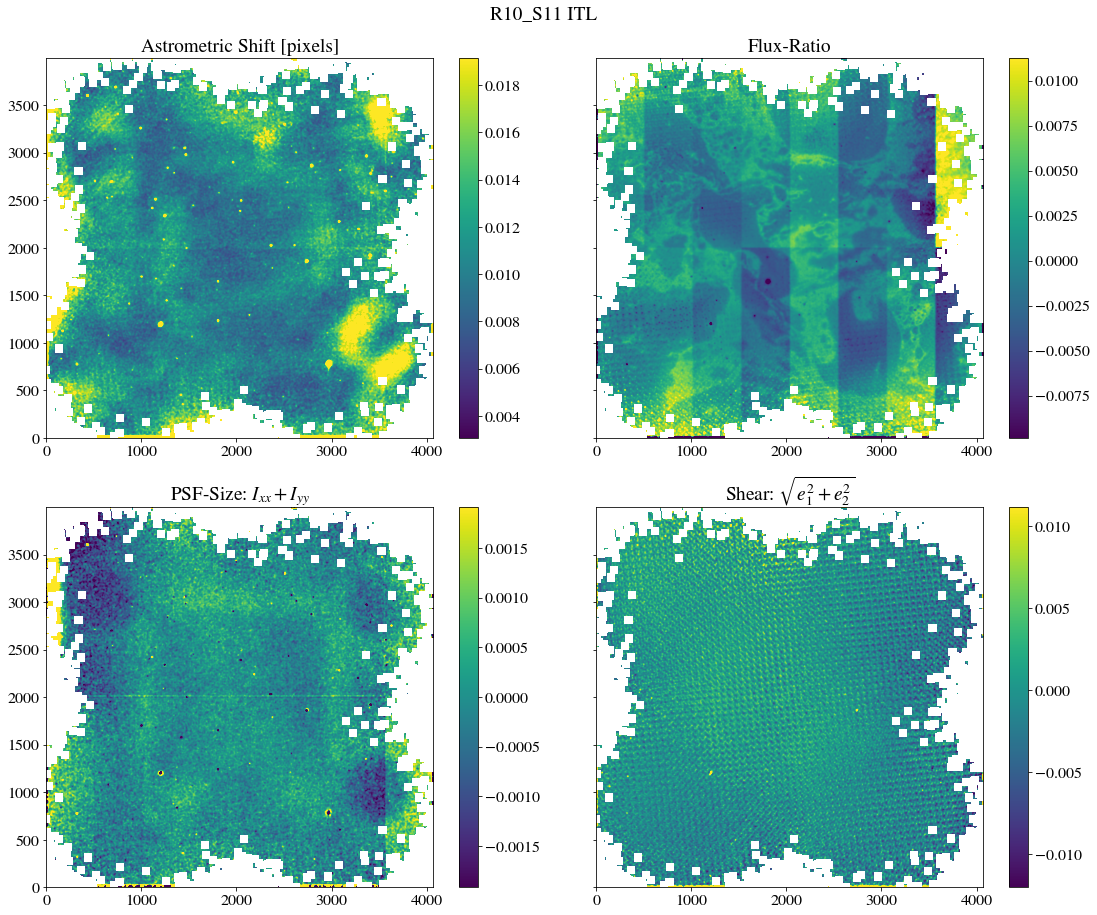

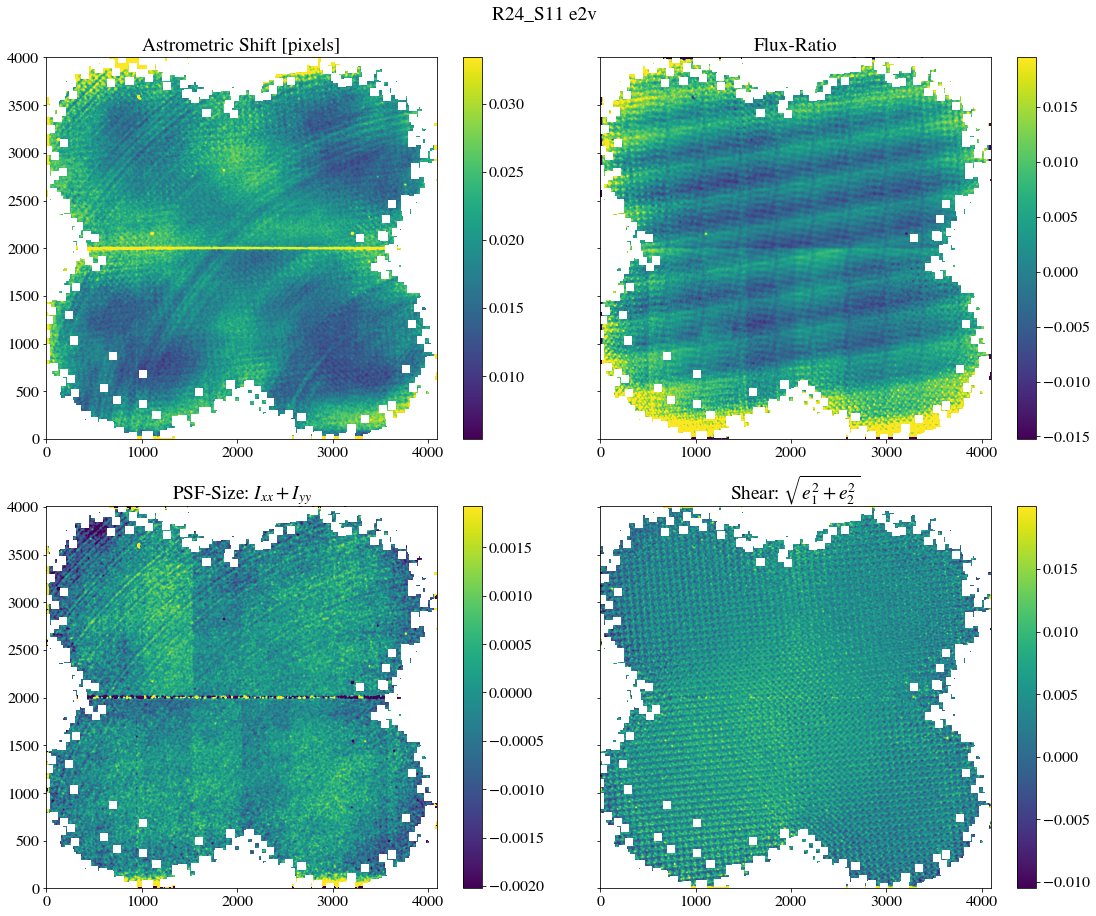

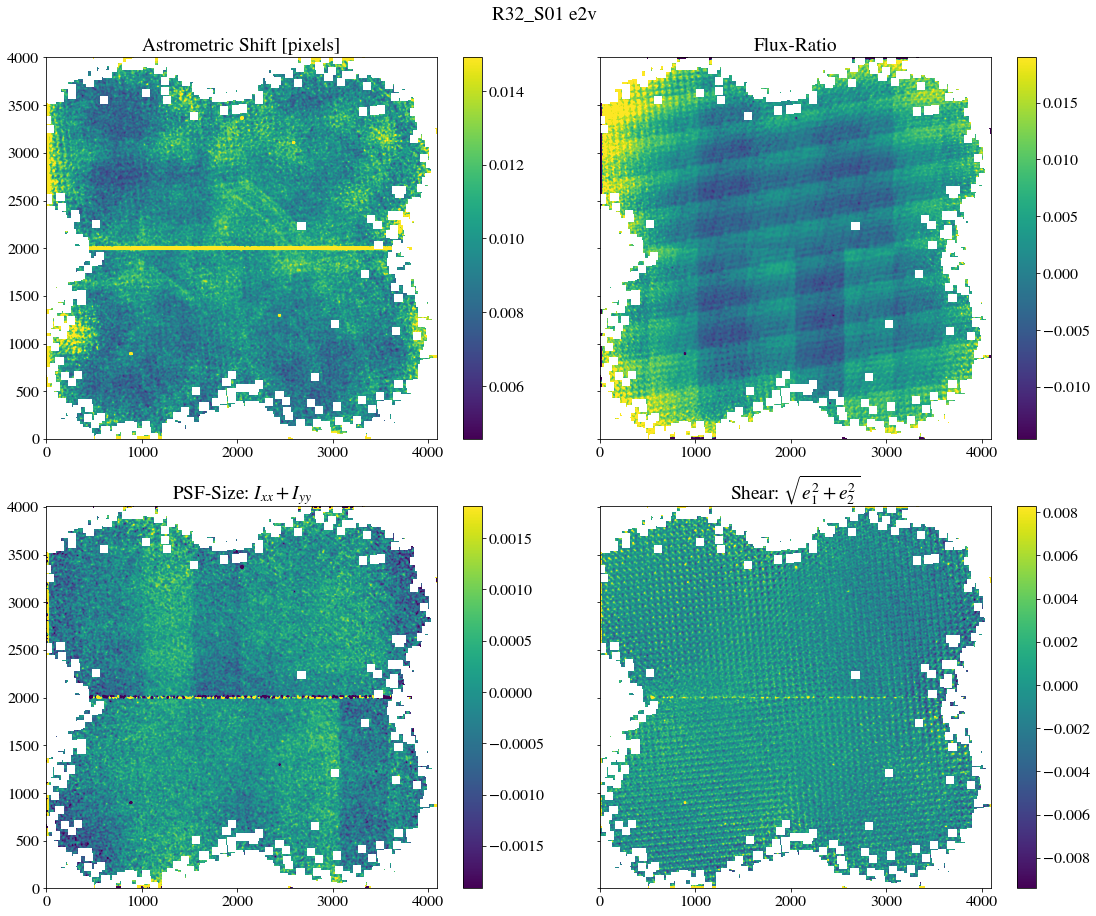

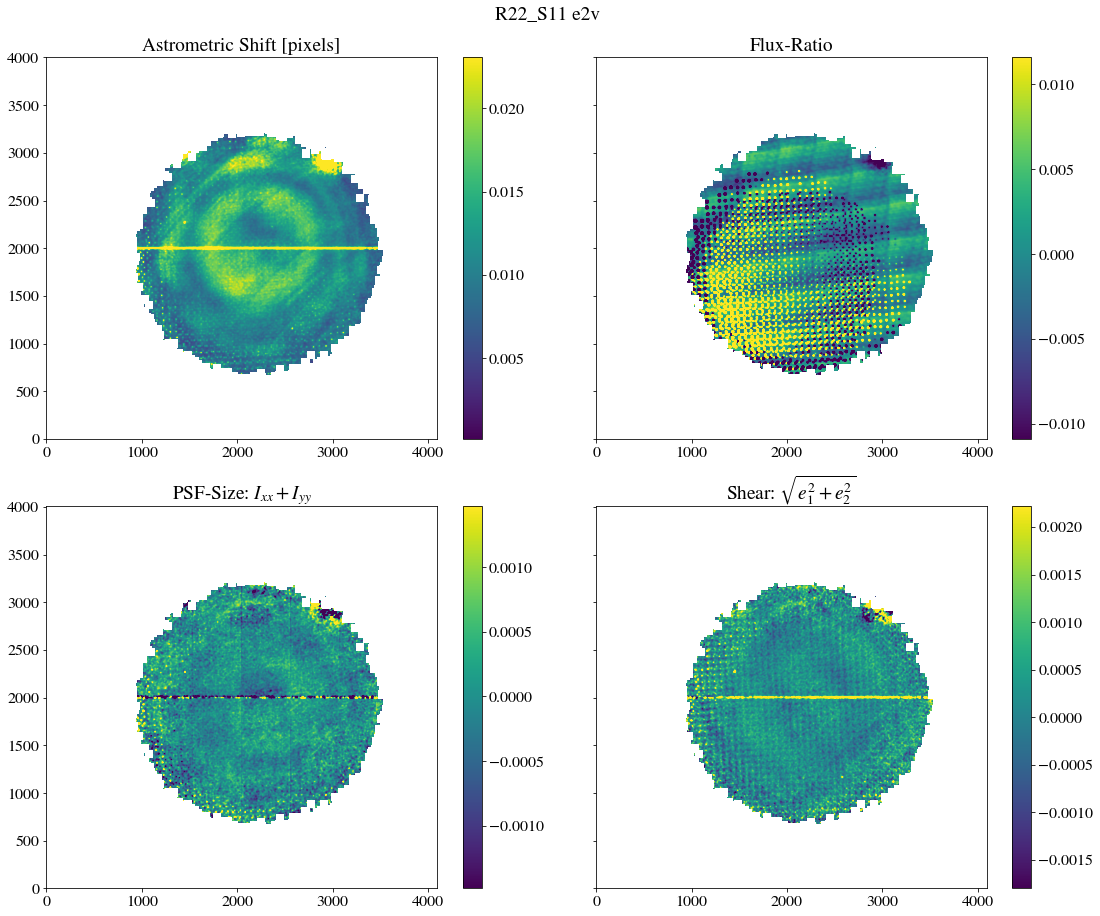

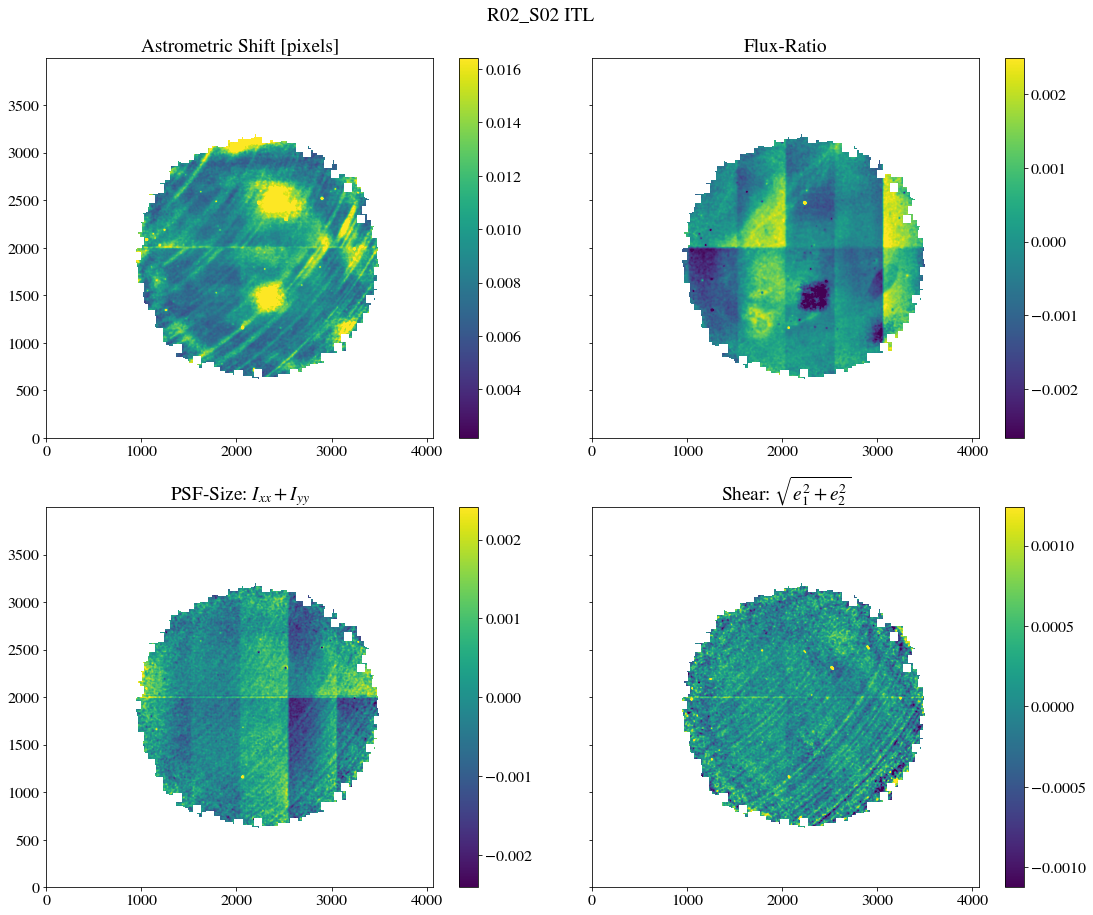

In [ ]:
for sensor in sensors:
    fig, axs = plt.subplots(2, 2, figsize=(16, 16*prop + 1), sharey='all', facecolor="white")

    fig.suptitle(f'{sensor.sensorbay.upper()} {sensor.sensor}')
    # maps = {}
    for ax, key, vals in zip(axs.flatten(), keys, keys.values()):
        #print(5*'---')
        #print(f'Variable: {key}')
        #print(f'component: {vals[0]}\n')

        _, img =  generate_image(sensor, key, vals[0], bins=[407,400])
        img_filtered = gaussian_filter(img,3)
        #img_filtered = apply_filter(img, 250, power=4) # power was 4

        std=mad_std(img_filtered, ignore_nan=True)
        m=np.nanmedian(img_filtered)
        a=ax.imshow(img_filtered,vmin=m-nsigma*std,vmax=m+nsigma*std)
        fig.colorbar(a,ax=ax)
        ax.set_title(vals[1])

    fig.tight_layout()
    plt.show()
    fig.savefig(f'{sensor.sensorbay}_figure1.pdf',dpi=100)

# Tree Ring Coordiante System

In [16]:
def proj_to_polar_coord(t,vx,vy):
    vr = np.cos(t)*vx + np.sin(t)*vy
    vt = -np.sin(t)*vx+ np.cos(t)*vy
    return vr, vt

def proj_to_polar_coord_spin2(t,vx,vy):
    vr = np.cos(2*t)*vx + np.sin(2*t)*vy
    vt = np.sin(2*t)*vx - np.cos(2*t)*vy
    return vr, vt

def trasnform_to_polar_coord(x,y,x0=0.,y0=0.,deg=False):
    r = np.hypot((x-x0),(y-y0))
    t = np.arctan2((y-y0),(x-x0))
    
    if deg: t *= (180 / np.pi)
    return r,t

In [17]:
centers = [[-335.49, 4095.84],[-156,-280],[4320,4180],[4627.47, -630.89]]

sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}

In [18]:
# for a given orientation and TR Center
def transform_to_treeRing_coords(self):
    xc,yc = centers[orientation_id]

    r, t = trasnform_to_polar_coord(self.xfltr_flat,self.yfltr_flat, x0=xc, y0=yc)

    dr,dt= proj_to_polar_coord(t,self.data['astrometric-shift']['x'],self.data['astrometric-shift']['y'])
    self.data['astrometric-shift']['r'] = dr
    self.data['astrometric-shift']['t'] = dt

    dr,dt= proj_to_polar_coord(t,self.data['psf-size']['x'],self.data['psf-size']['y'])
    self.data['psf-size']['r'] = dr
    self.data['psf-size']['t'] = dt

    # for spin2 quantities 
    dr,dt= proj_to_polar_coord_spin2(t,self.data['ellipticity']['x'],self.data['ellipticity']['y'])
    self.data['ellipticity']['r'] = dr
    self.data['ellipticity']['t'] = dt
    
    return self